In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
from decimal import Decimal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as DateTime
import scipy.stats as stats

# Configurando los estílos de los gráficos
plt.ioff()
sns.set_context('talk')
sns.set_style("whitegrid")

## Proceso

### Adquisición de datos

In [2]:
## Descargamos los datos
r = requests.get('https://admision.unmsm.edu.pe/simple/ResultadosSabado_12/A/011/0.html', verify=False)

C:\anaconda3\lib\site-packages\urllib3\connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'admision.unmsm.edu.pe'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


### Limpieza y transformación de datos

In [3]:
## Parseamos los datos
soup = BeautifulSoup(r.content, 'lxml')

In [4]:
## Creamos lista de elementos
rows = soup.find_all('tr')
elementsCount = len(rows) - 1
elements = []

for i in np.arange(1,elementsCount):
    row_data = rows[i].find_all('td')

    codigo = row_data[0].get_text()
    nombres = row_data[1].get_text()
    escuela = row_data[2].get_text()
    puntaje = row_data[3].get_text()

    if len(puntaje.strip()) > 0:
        elements.append({
            'codigo': codigo,
            'nombres': nombres,
            'escuela': escuela,
            'puntaje': Decimal(puntaje)
        })

_df = pd.DataFrame(elements, columns=['codigo','nombres','escuela','puntaje'])
_df.sort_values('puntaje', inplace=True)
_df.reset_index(drop=True, inplace=True)

## Resultados

<Figure size 432x288 with 0 Axes>

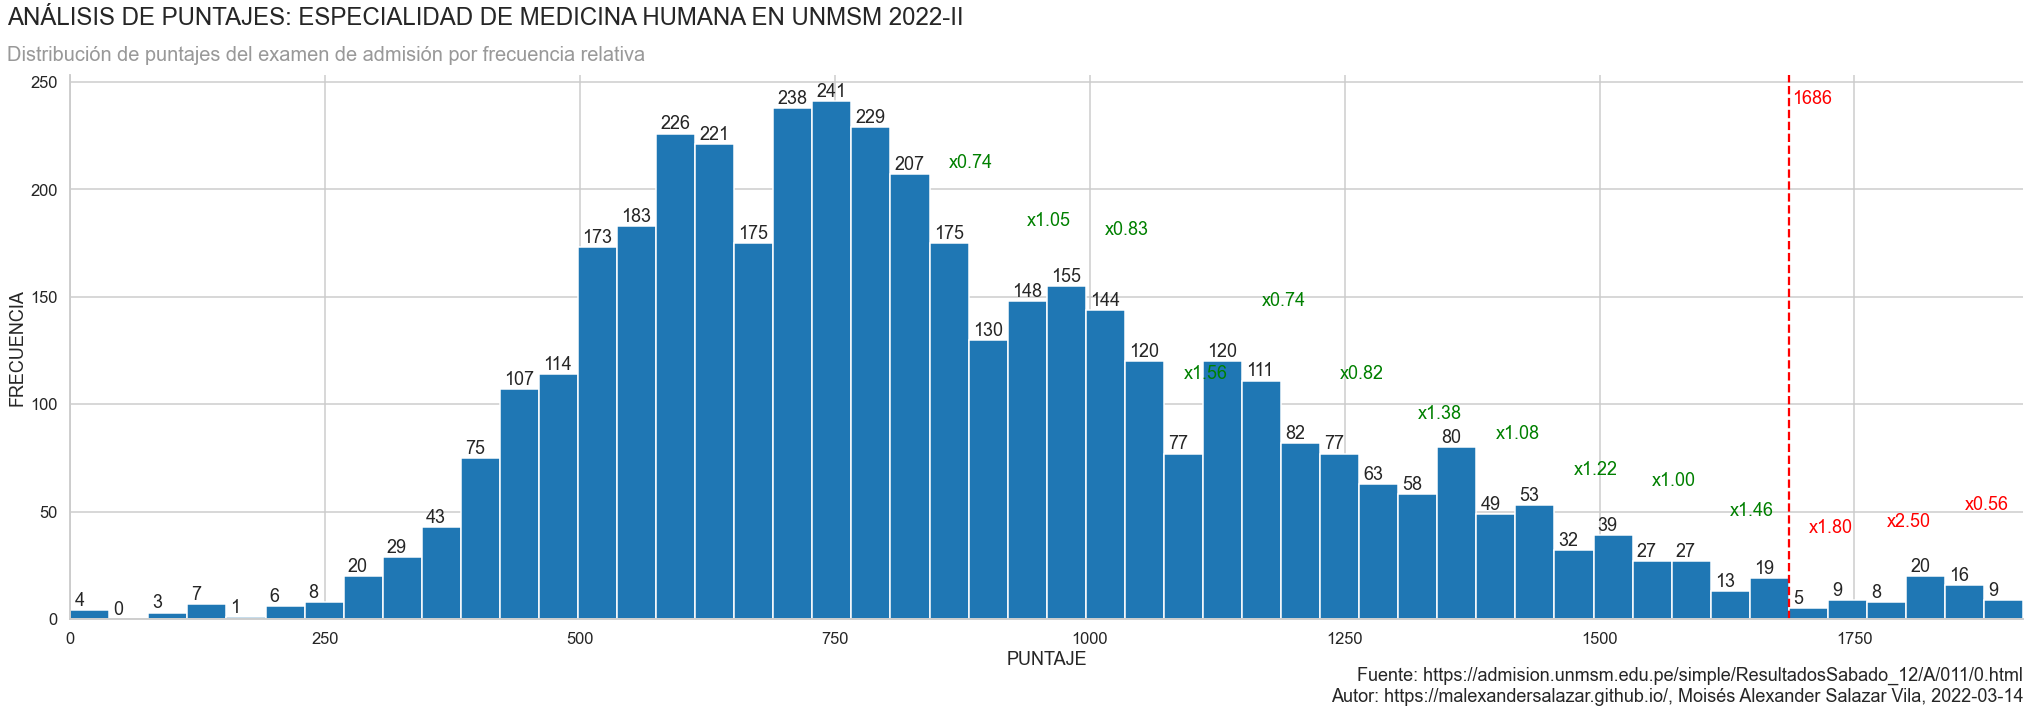

In [36]:
plt.clf()

fig, axs = plt.subplots(figsize=(35,10))
plt.figtext(0.1,0.95, 'ANÁLISIS DE PUNTAJES: ESPECIALIDAD DE MEDICINA HUMANA EN UNMSM 2022-II', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Distribución de puntajes del examen de admisión por frecuencia relativa', ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://admision.unmsm.edu.pe/simple/ResultadosSabado_12/A/011/0.html
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

n, bins, patches = plt.hist(_df['puntaje'], bins=50)

for i in np.arange(0,len(n)):
    plt.text(bins[i]+4, n[i]+2, int(n[i]))

    if(i < len(n) -1 and i % 2 == 0 and i > 20):
        f = n[i+1]/max(n[i],1)
        ff = "x" + "{:.2f}".format(f)

        if(i > 42):
            plt.text(bins[i]+bins[1]/2, n[i]+35, ff, color='r')
        else:
            plt.text(bins[i]+bins[1]/2, n[i]+35, ff, color='g')

plt.text(1689,240, 1686, color='r')
plt.axvline(1686, color='r', linestyle='--')

axs.set_xlim((_df["puntaje"].iat[0],_df["puntaje"].iat[-1]))
axs.set_xlabel('PUNTAJE')
axs.set_ylabel('FRECUENCIA')

sns.despine(left=False, bottom=False)

filename = 'dist/HIST.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


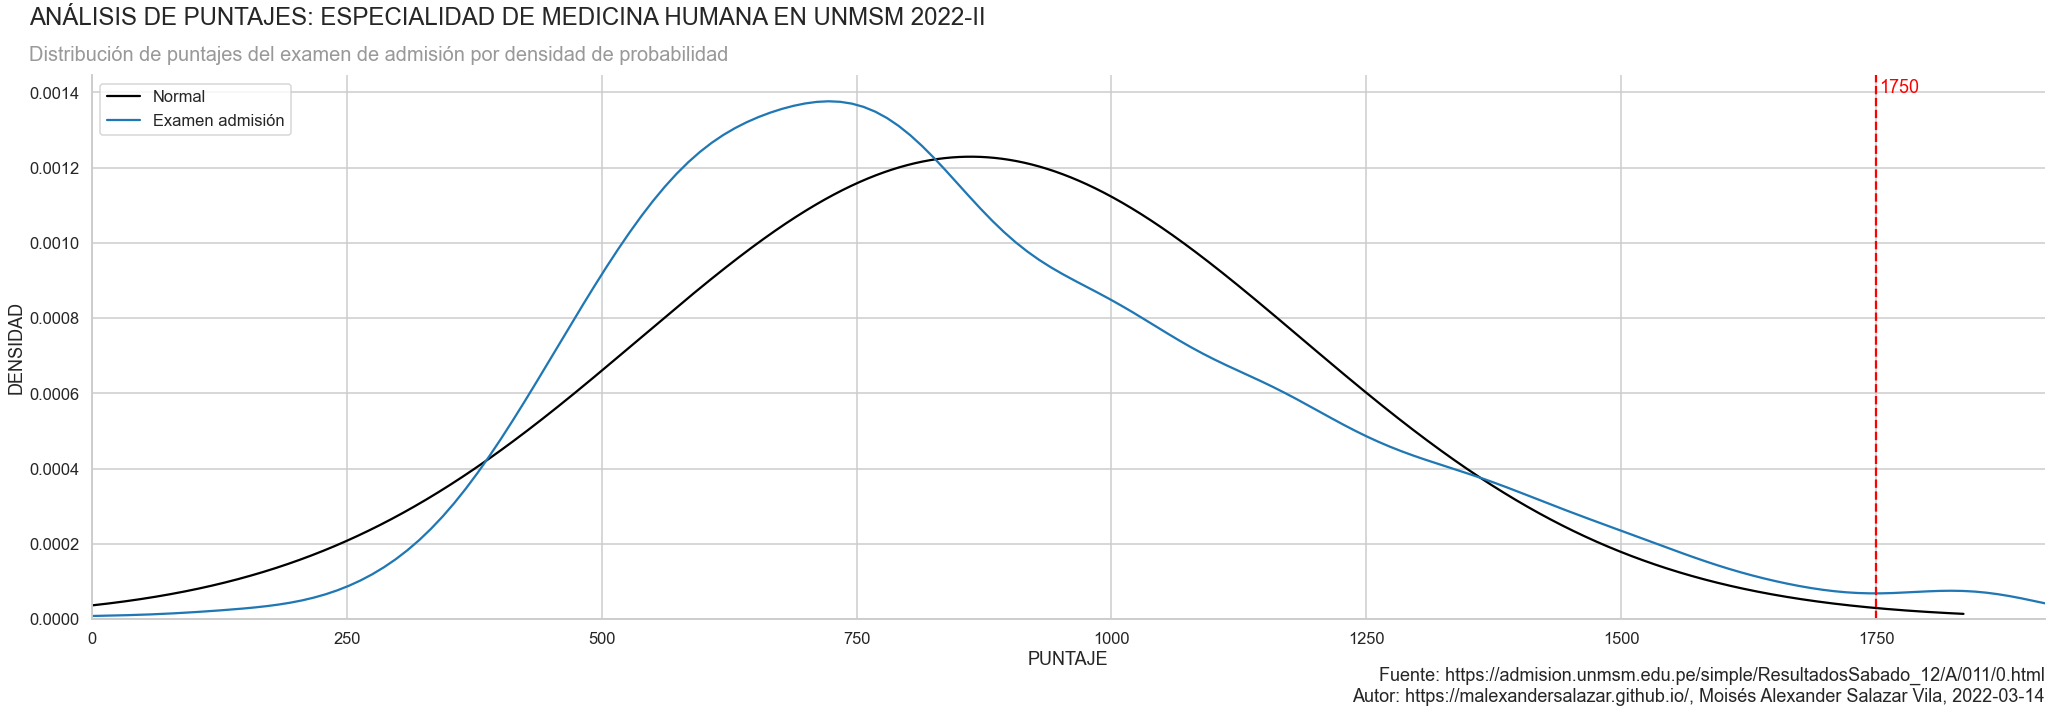

In [39]:
serie = _df["puntaje"].astype(float)
sigma = serie.std()
mu = serie.mean()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, len(serie))
normModel = (x, stats.norm.pdf(x, mu, sigma))

plt.close()

plt.subplots(figsize=(35,10))
plt.figtext(0.1,0.95, 'ANÁLISIS DE PUNTAJES: ESPECIALIDAD DE MEDICINA HUMANA EN UNMSM 2022-II', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Distribución de puntajes del examen de admisión por densidad de probabilidad', ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://admision.unmsm.edu.pe/simple/ResultadosSabado_12/A/011/0.html
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

sns.lineplot(normModel[0], normModel[1], color="#000", label = 'Normal')
sns.kdeplot(_df['puntaje'], label = 'Examen admisión')

plt.text(1753,0.0014, 1750, color='r')
plt.axvline(1750, 0, 100, color='r', linestyle='--')

plt.xlim((_df["puntaje"].iat[0],_df["puntaje"].iat[-1]))
plt.xlabel("PUNTAJE")
plt.ylabel("DENSIDAD")

plt.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/NORM.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()

In [16]:
puntajes_delta = pd.Series(n).diff()
weekly_up = puntajes_delta.clip(lower=0)
weekly_down = -1*puntajes_delta.clip(upper=0)

ema_up = weekly_up.ewm(com=14,adjust=False).mean()
ema_down = weekly_down.ewm(com=14,adjust=False).mean()
weekly_rs = ema_up/ema_down
weekly_rsi = 100-(100/(1+weekly_rs))
weekly_rsi.fillna(method='bfill',inplace=True)

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

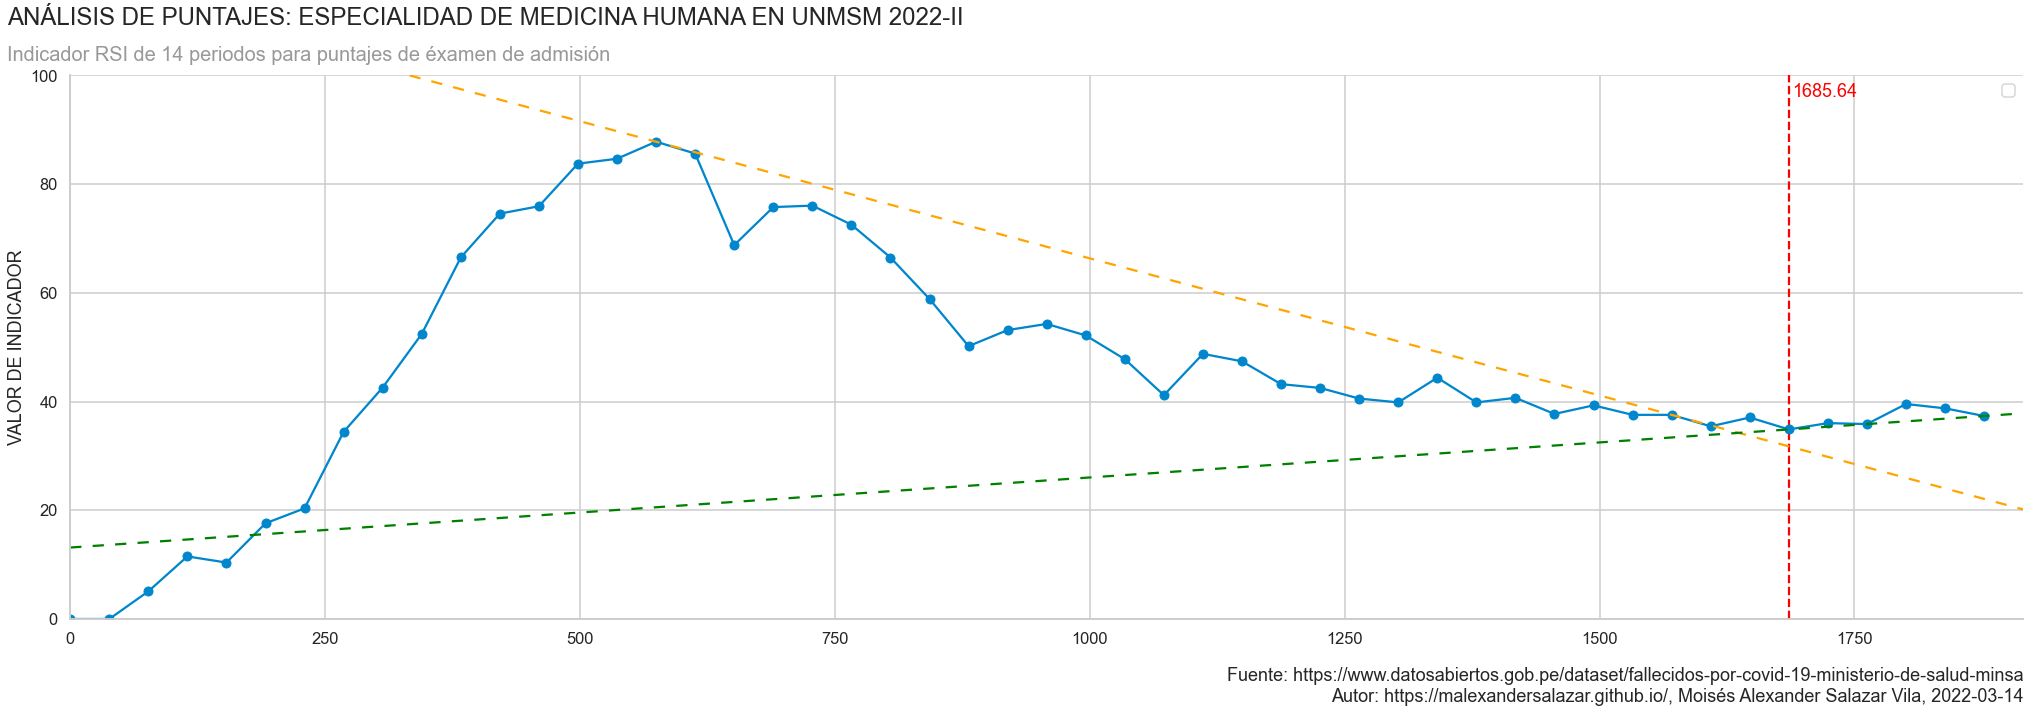

In [33]:
plt.clf()

fig, axs = plt.subplots(figsize=(35,10))
plt.figtext(0.1,0.95, 'ANÁLISIS DE PUNTAJES: ESPECIALIDAD DE MEDICINA HUMANA EN UNMSM 2022-II', ha='left', fontsize=24)
plt.figtext(0.1,0.90, 'Indicador RSI de 14 periodos para puntajes de éxamen de admisión', ha='left', fontsize=20, color='#999')
plt.figtext(0.9,0.01, """Fuente: https://www.datosabiertos.gob.pe/dataset/fallecidos-por-covid-19-ministerio-de-salud-minsa
Autor: https://malexandersalazar.github.io/, Moisés Alexander Salazar Vila, """ + f'{DateTime.now():%Y-%m-%d}', ha='right')

axs.plot(bins[:-1], weekly_rsi, 'o-', color='#0086CD')
axs.axline((bins[15], weekly_rsi[15]), (bins[41], weekly_rsi[41]), c='orange', linestyle=(0, (5, 5)))
axs.axline((bins[44], weekly_rsi[44]), (bins[46], weekly_rsi[46]), c='g', linestyle=(0, (5, 5)))
axs.text(bins[44]+3,96, bins[44], color='r')
axs.vlines(bins[44], 0, 100, color='r', linestyle='--')

axs.set_xlim((_df["puntaje"].iat[0],_df["puntaje"].iat[-1]))
axs.set_ylim(0,100)
axs.set_ylabel('VALOR DE INDICADOR')
axs.legend()

sns.despine(left=False, bottom=False)

filename = 'dist/RSI.png'
plt.savefig("../" + filename, bbox_inches='tight')

plt.show()
plt.close(fig)